In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/BraTS20_flair")

In [ ]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1660


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Create the train dataset (70% of the data)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # Use validation_split for data splitting
    subset="training",  # Use "training" subset for the training set
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Create the validation dataset (15% of the data)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # Use validation_split for data splitting
    subset="validation",  # Use "validation" subset for the validation set
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Create the test dataset (15% of the data)
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,  # Use validation_split for data splitting
    subset="validation",  # Use "validation" subset for the test set
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1660 files belonging to 2 classes.
Using 1162 files for training.
Found 1660 files belonging to 2 classes.
Using 498 files for validation.
Found 1660 files belonging to 2 classes.
Using 249 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['NoTumor', 'Tumor']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

# Assuming you have separate datasets for train, validation, and test
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.7559672


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
37/37 [==============================] - 6s 81ms/step - loss: 0.5716 - accuracy: 0.7668 - val_loss: 0.4389 - val_accuracy: 0.8554
Epoch 2/10
37/37 [==============================] - 1s 22ms/step - loss: 0.4448 - accuracy: 0.8184 - val_loss: 0.4428 - val_accuracy: 0.8454
Epoch 3/10
37/37 [==============================] - 1s 22ms/step - loss: 0.3836 - accuracy: 0.8520 - val_loss: 0.3452 - val_accuracy: 0.8755
Epoch 4/10
37/37 [==============================] - 1s 22ms/step - loss: 0.3118 - accuracy: 0.8735 - val_loss: 0.3466 - val_accuracy: 0.8715
Epoch 5/10
37/37 [==============================] - 1s 22ms/step - loss: 0.2471 - accuracy: 0.8881 - val_loss: 0.3058 - val_accuracy: 0.8896
Epoch 6/10
37/37 [==============================] - 1s 24ms/step - loss: 0.2151 - accuracy: 0.9088 - val_loss: 0.3000 - val_accuracy: 0.8715
Epoch 7/10
37/37 [==============================] - 1s 24ms/step - loss: 0.1562 - accuracy: 0.9337 - val_loss: 0.4692 - val_accuracy: 0.8414
Epoch 8/10
37

8/8 [==============================] - 1s 46ms/step - loss: 0.3985 - accuracy: 0.8996
Training Loss: 0.05555208399891853
Training Accuracy: 0.9862306118011475
Validation Loss: 0.41764700412750244
Validation Accuracy: 0.8835341334342957
Test Loss: 0.3984588384628296
Test Accuracy: 0.8995984196662903


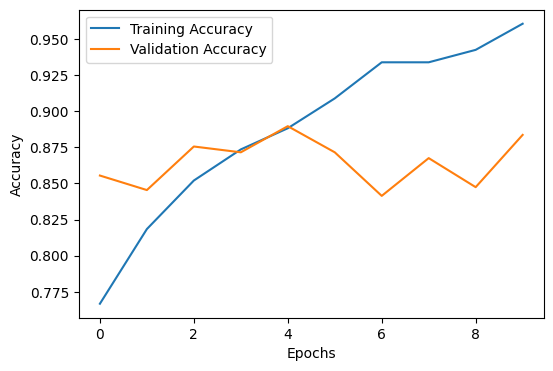

In [ ]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(train_ds)
val_loss, val_accuracy = model.evaluate(val_ds)
test_loss, test_accuracy = model.evaluate(test_ds)
print('Training Loss:', train_loss)
print('Training Accuracy:', train_accuracy)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Plot the training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

8/8 [==============================] - 0s 18ms/step


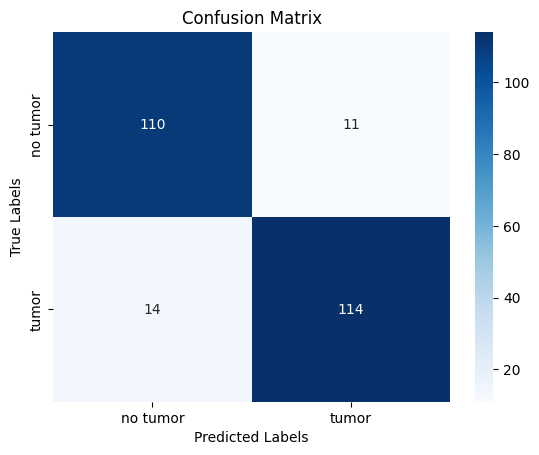

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the predicted labels for the test dataset
test_predictions = model.predict(test_ds).argmax(axis=1)

# Get the true labels for the test dataset
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Define the class names
class_names = ['no tumor', 'tumor']  # Modify with your actual class names

# Create the confusion matrix
confusion = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix with class names
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()